# Master pipeline notebook


### This notebook follows the ML pipeline process of gathering data, performing analysis, modelling and evaluation


The process involves: 
1. Data gathering and pre-processing
2. Data analysis
3. Feature engineering 
4. Data transformation
5. LSTM Modelling 
6. Evaluation


_Note: Run the notebook from start to end._


In [1]:
import numpy as np
import pandas as pd
from data import gatherData
import plotly.graph_objects as go
from pre_process_data import processData
from feature import engineerFeaturesForTraining, splitData
from transform import transformData
from utils import load_config_file, save_as_pickle
from train import train
import plotly.figure_factory as ff
import torch
from LSTM_model import LSTM
from inference import makeInference
from evaluation import evaluateModellingResults
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import random

In [2]:
config = load_config_file("config.yml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data gathering and pre-processing

- Gather the data 
- Pre process it:
    - Merge columns from races_df and results_df
    - Add columns from pit_stop_df
    - Work on the outliers in the data
    - remove race_ids with less that 8 data points


In [3]:
gather_data_obj = gatherData(config=config)

In [4]:
(
    lap_times_df,
    pit_stops_df,
    qualifying_df,
    races_df,
    results_df,
    sprint_results_df,
    status_df,
) = gather_data_obj.load_data()

In [5]:
pre_process_obj = processData(config=config)

master_lap_times_df = pre_process_obj.create_initial_dataset(
    lap_times_df=lap_times_df, races_df=races_df, results_df=results_df
)
master_lap_times_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1


In [6]:
# check for nans in the data
master_lap_times_df.isna().any()

raceId          False
driverId        False
lap             False
position        False
milliseconds    False
year            False
round           False
circuitId       False
name            False
date            False
number          False
statusId        False
dtype: bool

In [7]:
driver_id = 20
race_id = 841

lap_times_selected_driver_race = master_lap_times_df[
    (master_lap_times_df["raceId"] == race_id)
    & (master_lap_times_df["driverId"] == driver_id)
]

In [8]:
## Lap times and pit stops

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=lap_times_selected_driver_race["lap"],
        y=lap_times_selected_driver_race["milliseconds"],
        mode="lines+markers",
        name="Lap times in milliseconds",
    )
)

fig.update_layout(
    title="Laptimes by each lap", xaxis_title="Lap number", yaxis_title="Total lap time"
)

- Two outliers in the data 
- this is mainly the pit stops that happen in between the race

In [9]:
master_laptimes_pitstop_df = pre_process_obj.add_pitstop_data(
    master_laptime_data=master_lap_times_df, pit_stop_data=pit_stops_df
)
master_laptimes_pitstop_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId,pitStopMilliseconds,isPitStop
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False


In [10]:
driver_id = 20
lap_times_selected_driver = master_laptimes_pitstop_df[
    (master_laptimes_pitstop_df["driverId"] == driver_id)
]

In [11]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=lap_times_selected_driver["milliseconds"], name="Lap times for Aus GP")
)

# Customize the layout
fig.update_layout(
    title="Box Plot with plotly.graph_objects",
    yaxis_title="Values",
)

# Show the figure
fig.show()

In [12]:
master_lap_time_data = pre_process_obj.work_on_outliers(
    master_lap_time_data=lap_times_selected_driver
)

## Data Analysis

In [13]:
histvalues = [master_lap_time_data["milliseconds"]]
names = ["lap times"]

fig = ff.create_distplot(
    histvalues,
    names,
    bin_size=10000,
    show_rug=False,
    curve_type="kde",
    histnorm="probability",
)

fig.show()

In [14]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=master_lap_time_data["milliseconds"], name="Lap times for all GPs")
)

# Customize the layout
fig.update_layout(
    title="Box Plot for millisecond for all GPs",
    yaxis_title="Lap times (milliseconds)",
)

# Show the figure
fig.show()

In [15]:
master_lap_time_data

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId,pitStopMilliseconds,isPitStop
0,841,20,1,1,98109.0,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
1,841,20,2,1,93006.0,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
2,841,20,3,1,92713.0,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
3,841,20,4,1,92803.0,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
4,841,20,5,1,92342.0,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537518,1096,20,54,11,90931.0,2022,22,24,Abu Dhabi Grand Prix,2022-11-20,5,1,0.0,False
537519,1096,20,55,11,91304.0,2022,22,24,Abu Dhabi Grand Prix,2022-11-20,5,1,0.0,False
537520,1096,20,56,10,91485.0,2022,22,24,Abu Dhabi Grand Prix,2022-11-20,5,1,0.0,False
537521,1096,20,57,10,91227.0,2022,22,24,Abu Dhabi Grand Prix,2022-11-20,5,1,0.0,False


In [16]:
fig = go.Figure()

circuit_id = 1

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )
    condition = lap_times_race["isPitStop"]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=12, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

#### Normal race scenario
- RaceId: 841
    - Two pit stops time: lap times increased during those points
#### Outlier situation
- RaceId: 860
    - Two pit stops, but lap time were still grater than normal
    - why? - Red flag or yellow flag? other outside factors?

In [17]:
fig = go.Figure()

circuit_id = 12

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    condition = lap_times_race["isPitStop"]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=12, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

#### Another situation:
- No pitstops in race_id: 345, missing data: need to add pitstops to these races:
    - first greater than average lap times would be regarded as pit stops 

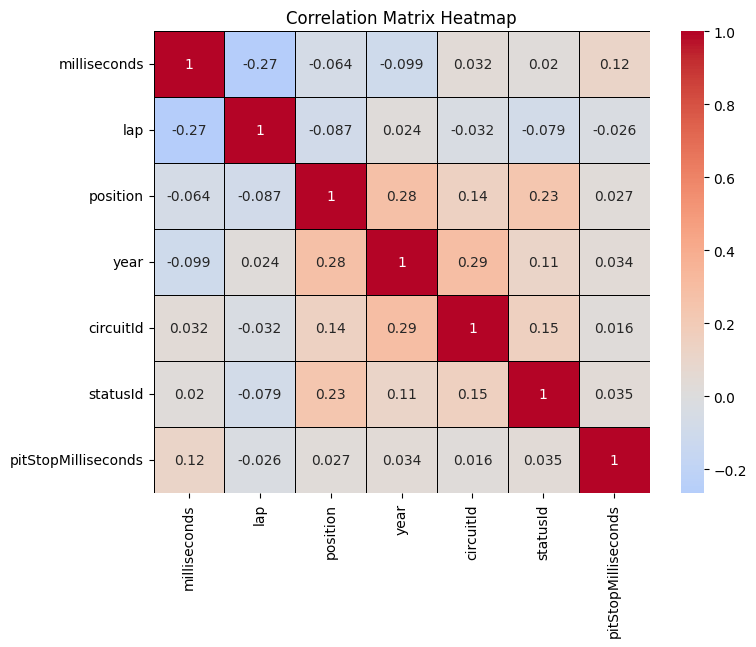

In [18]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "circuitId",
    "statusId",
    "pitStopMilliseconds",
]

master_lap_time_data_corr_matrix = master_lap_time_data[columns_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_lap_time_data_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

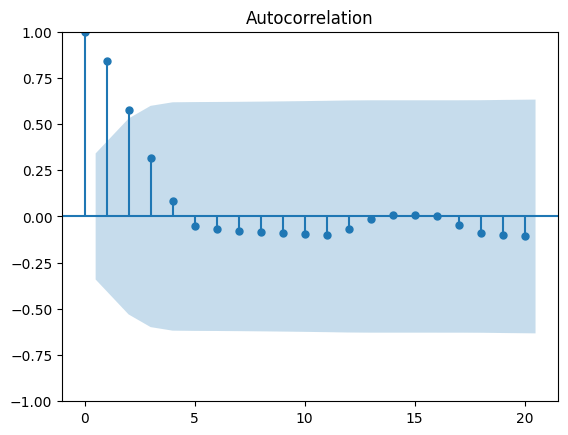

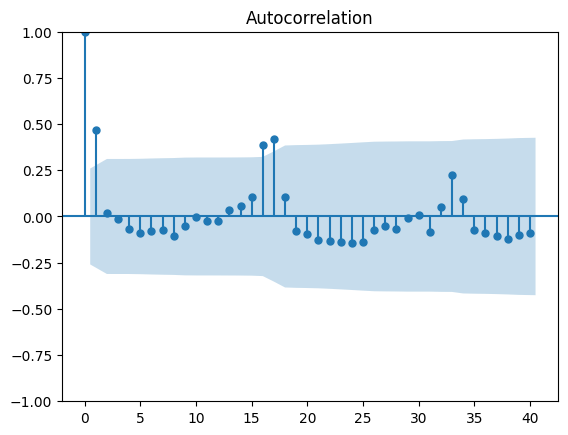

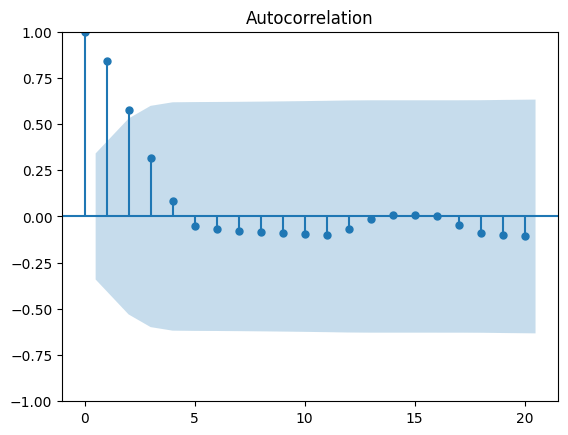

In [19]:
lap_times_race_848 = master_lap_time_data[master_lap_time_data["raceId"] == 848]

lap_times_race_867 = master_lap_time_data[master_lap_time_data["raceId"] == 867]

plot_acf(lap_times_race_848["milliseconds"], lags=40)
plot_acf(lap_times_race_867["milliseconds"], lags=20)

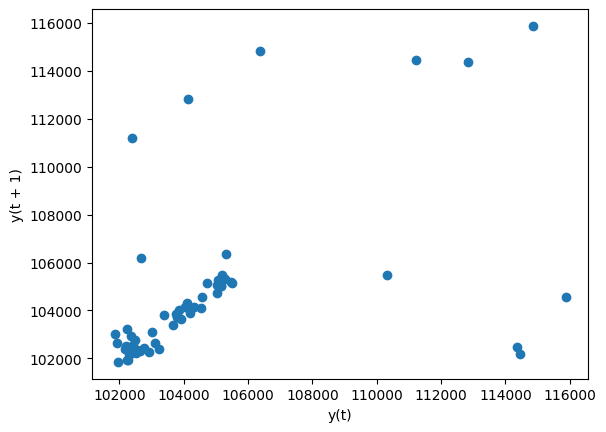

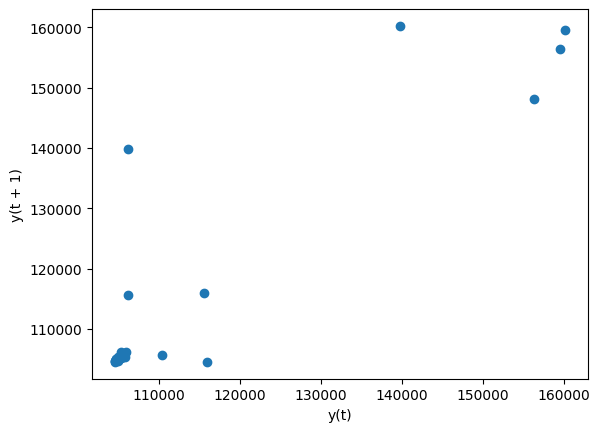

In [20]:
pd.plotting.lag_plot(lap_times_race_848["milliseconds"], lag=1)
plt.show()

pd.plotting.lag_plot(lap_times_race_867["milliseconds"], lag=1)
plt.show()

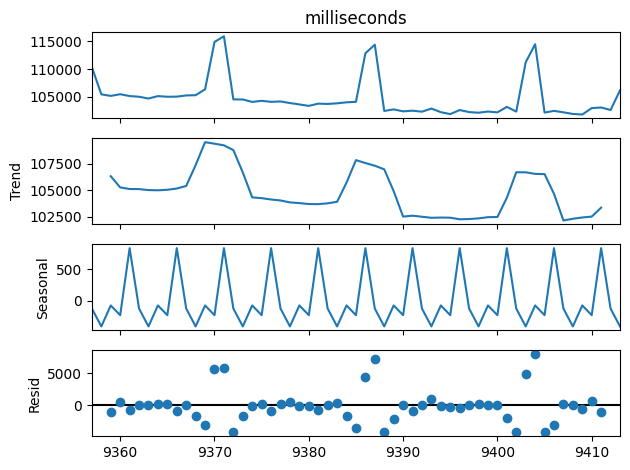

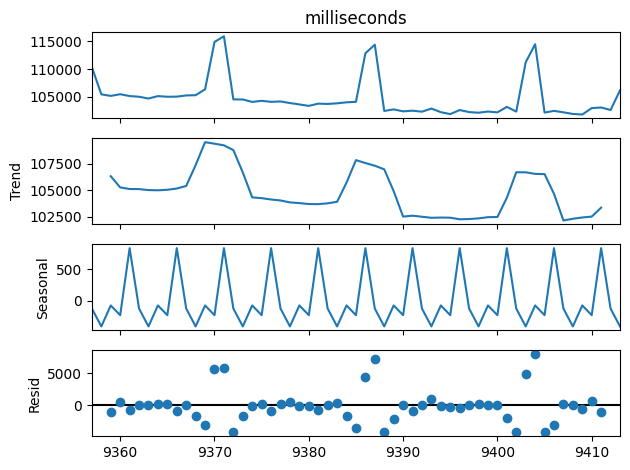

In [21]:
result = seasonal_decompose(
    lap_times_race_848["milliseconds"], model="additive", period=5
)
result.plot()

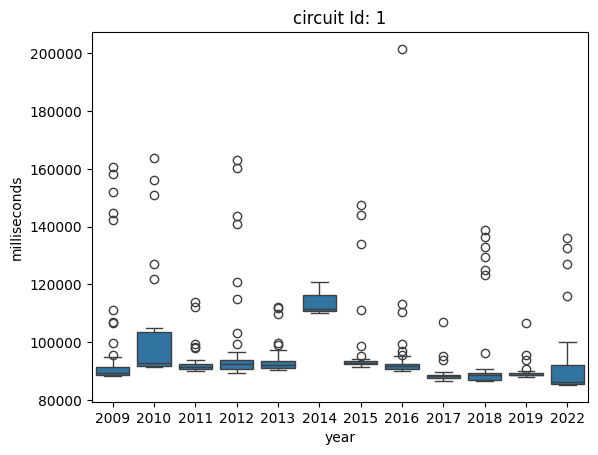

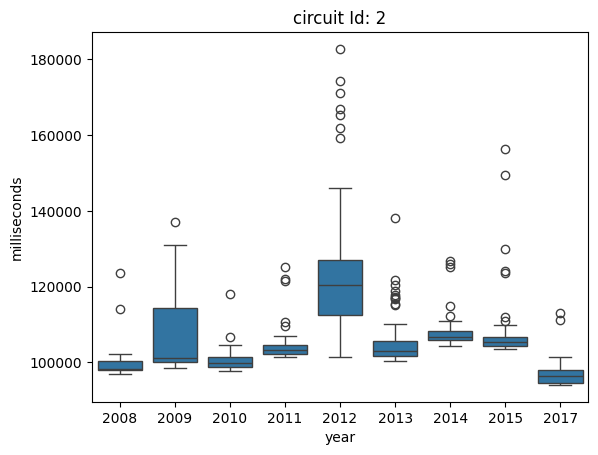

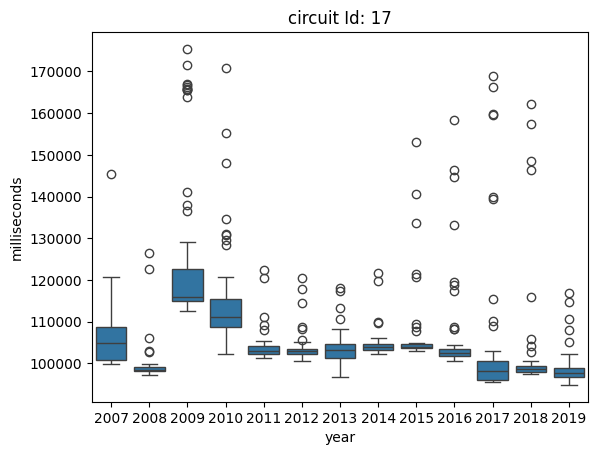

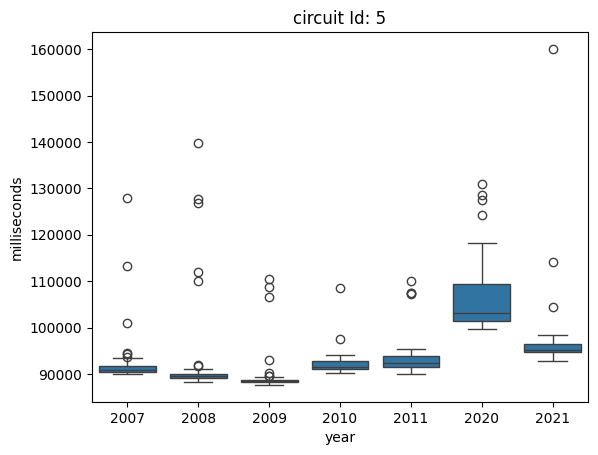

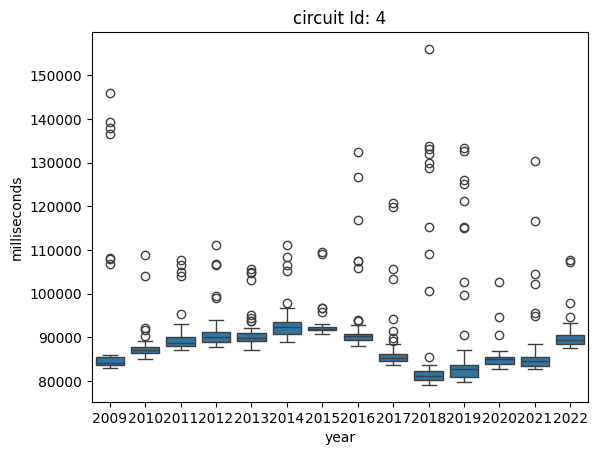

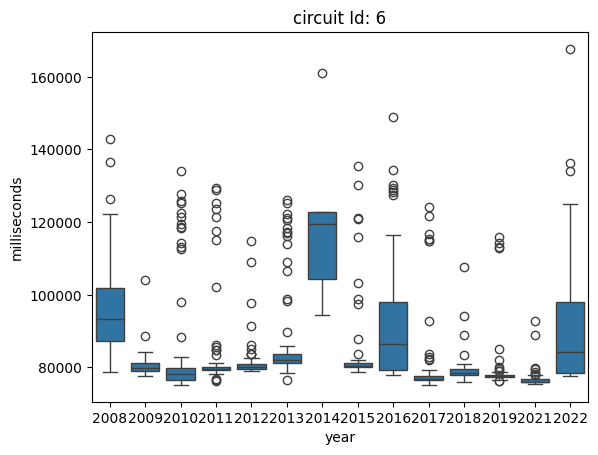

In [22]:
ls_circuit_id = [1, 2, 17, 5, 4, 6]

for c_id in ls_circuit_id:
    lap_times_circuit = master_lap_time_data[master_lap_time_data["circuitId"] == c_id]

    sns.boxplot(x="year", y="milliseconds", data=lap_times_circuit)
    plt.title(f"circuit Id: {c_id}")
    plt.show()

## Feature Engineering

- Add columns that can help in modelling
    - add date feature columns
    - add lagged features: previous_lap_time, previous_lap_position, previous_lap_number
    - one hot encode the categorical features

In [23]:
engineer_data_obj = engineerFeaturesForTraining(config=config)


engineered_lap_times_df, encoder, encoder_columns = engineer_data_obj.engineer_data(
    lap_times_data=master_lap_time_data
)

In [24]:
engineered_lap_times_df

,raceId,lap,position,milliseconds,year,isPitStop,pitStopMilliseconds,PitStopIndicator,lapDifference,milliseconds_1_prior,...,circuitId_68,circuitId_69,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79
1,1,2,2,91173.0,2009,0,0.0,0,-8474.0,99647.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,2,89752.0,2009,0,0.0,0,-1421.0,91173.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,2,88999.0,2009,0,0.0,0,-753.0,89752.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,2,88849.0,2009,0,0.0,0,-150.0,88999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,2,88424.0,2009,0,0.0,0,-425.0,88849.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,1096,54,11,90931.0,2022,0,0.0,1,-125.0,91056.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16395,1096,55,11,91304.0,2022,0,0.0,1,373.0,90931.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16396,1096,56,10,91485.0,2022,0,0.0,1,181.0,91304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16397,1096,57,10,91227.0,2022,0,0.0,1,-258.0,91485.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
fig = go.Figure()


for race_id in list_race_id:

    lap_times_race = engineered_lap_times_df[
        engineered_lap_times_df["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds_1_prior"],
            mode="lines+markers",
            name=f"race id: {race_id} 1 prior",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap and prior lap {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

In [26]:
engineered_lap_times_df.columns

Index(['raceId', 'lap', 'position', 'milliseconds', 'year', 'isPitStop',
       'pitStopMilliseconds', 'PitStopIndicator', 'lapDifference',
       'milliseconds_1_prior', 'lap_number_1_prior', 'position_1_prior_lap',
       'pitStopMilliseconds_1_prior', 'isPitStop_1_prior',
       'PitStopIndicator_1_prior', 'lapDifference_1_prior', 'month', 'day',
       'circuitId_1', 'circuitId_2', 'circuitId_3', 'circuitId_4',
       'circuitId_5', 'circuitId_6', 'circuitId_7', 'circuitId_8',
       'circuitId_9', 'circuitId_10', 'circuitId_11', 'circuitId_12',
       'circuitId_13', 'circuitId_14', 'circuitId_15', 'circuitId_16',
       'circuitId_17', 'circuitId_18', 'circuitId_19', 'circuitId_20',
       'circuitId_21', 'circuitId_22', 'circuitId_24', 'circuitId_32',
       'circuitId_34', 'circuitId_35', 'circuitId_39', 'circuitId_68',
       'circuitId_69', 'circuitId_70', 'circuitId_71', 'circuitId_73',
       'circuitId_75', 'circuitId_76', 'circuitId_77', 'circuitId_78',
       'circuitId_

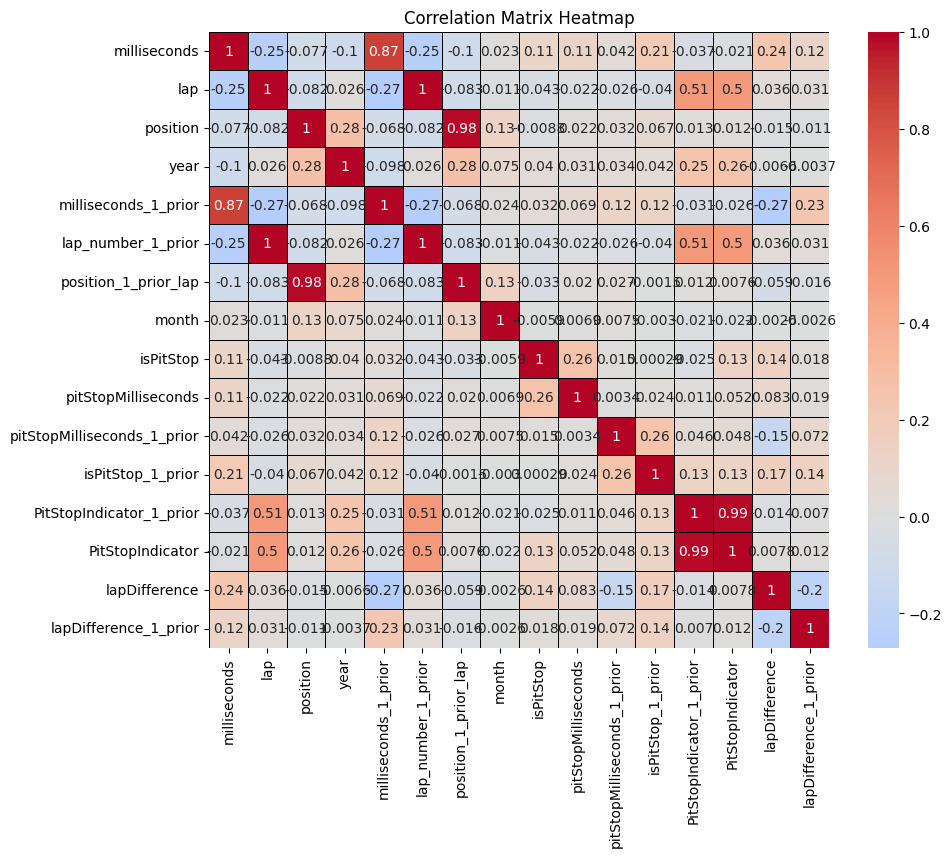

In [27]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "milliseconds_1_prior",
    "lap_number_1_prior",
    "position_1_prior_lap",
    "month",
    "isPitStop",
    "pitStopMilliseconds",
    "pitStopMilliseconds_1_prior",
    "isPitStop_1_prior",
    "PitStopIndicator_1_prior",
    "PitStopIndicator",
    "lapDifference",
    "lapDifference_1_prior",
]

engineered_lap_times_df_corr_matrix = engineered_lap_times_df[columns_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    engineered_lap_times_df_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [28]:
# drop columns to avoid data leak
engineered_lap_times_df = engineered_lap_times_df.drop(
    columns=config.get("DROP_COLUMNS_AVOID_LEAKAGE")
)
engineered_lap_times_df = engineered_lap_times_df.drop(
    columns=config.get("DROP_COLUMNS_CORR")
)
engineered_lap_times_df.columns

Index(['raceId', 'lap', 'milliseconds', 'year', 'milliseconds_1_prior',
       'position_1_prior_lap', 'isPitStop_1_prior', 'lapDifference_1_prior',
       'circuitId_1', 'circuitId_2', 'circuitId_3', 'circuitId_4',
       'circuitId_5', 'circuitId_6', 'circuitId_7', 'circuitId_8',
       'circuitId_9', 'circuitId_10', 'circuitId_11', 'circuitId_12',
       'circuitId_13', 'circuitId_14', 'circuitId_15', 'circuitId_16',
       'circuitId_17', 'circuitId_18', 'circuitId_19', 'circuitId_20',
       'circuitId_21', 'circuitId_22', 'circuitId_24', 'circuitId_32',
       'circuitId_34', 'circuitId_35', 'circuitId_39', 'circuitId_68',
       'circuitId_69', 'circuitId_70', 'circuitId_71', 'circuitId_73',
       'circuitId_75', 'circuitId_76', 'circuitId_77', 'circuitId_78',
       'circuitId_79'],
      dtype='object')

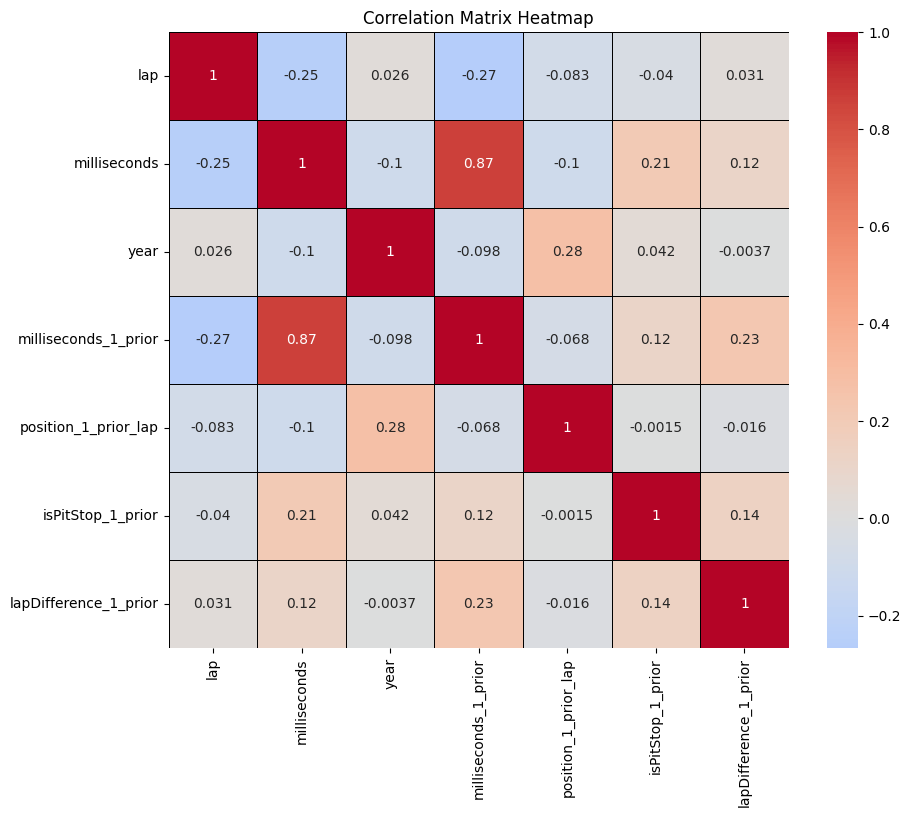

In [29]:
columns_for_corr = [
    "lap",
    "milliseconds",
    "year",
    "milliseconds_1_prior",
    "position_1_prior_lap",
    "isPitStop_1_prior",
    "lapDifference_1_prior",
]

engineered_lap_times_df_corr_matrix = engineered_lap_times_df[columns_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    engineered_lap_times_df_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Spliting into train test

 - First a race_id is selected which will act as an unseen set, and the model will perform predictions on it

In [30]:
split_obj = splitData()

train_data, test_data = split_obj.train_test_split(
    data=engineered_lap_times_df, race_id_list=config.get("RACE_ID_TEST_SET")
)

# Transform data for LSTM model
- scaling 
    - Scale each numerical column using appropriate scaler
- sequencing
    - all scaled and categorical columns are combined 
    - the dataframe is then converted to a sequential tensor

In [31]:
data_transform_obj = transformData(
    n_steps_input=config.get("NUMBER_OF_HISTORICAL_LAP"),
    n_steps_output=config.get("N_STEP_OUTPUT"),
    config=config,
)

scaled_input_df_train, scaled_output_df_train = (
    data_transform_obj.create_scaled_input_output_data(data=train_data, train=True)
)

INFO:root:scaler_dict.pkl saved to ../artifacts/


In [32]:
x_sequential_train, y_sequential_train = data_transform_obj.create_sequence(
    scaled_input_df=scaled_input_df_train, scaled_output_df=scaled_output_df_train
)

In [33]:
x_train, x_val, y_train, y_val = split_obj.train_validation_split(
    x_sequential_ls=x_sequential_train, y_sequential_ls=y_sequential_train
)

In [34]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

x_train = torch.reshape(
    x_train,
    (
        x_train.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_train.shape[2],
    ),
)

x_validation = torch.Tensor(x_val)
y_validation = torch.Tensor(y_val)

x_validation = torch.reshape(
    x_validation,
    (
        x_validation.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_validation.shape[2],
    ),
)

## Model training
- Create data loader for the LSTM model
- define LSTM model architecture
- define training loop
- train and save the model 

In [35]:
train_obj = train(config=config)

train_data_loader, validation_data_loader = train_obj.create_data_loader(
    batch_size=config.get("BATCH_SIZE"),
    x_train=x_train,
    y_train=y_train,
    x_validation=x_validation,
    y_validation=y_validation,
)

In [36]:
x_train.shape

torch.Size([11628, 2, 43])

In [37]:
lstm_model = LSTM(
    num_classes=config.get("N_STEP_OUTPUT"),
    input_size=x_train.shape[2],
    hidden_size_layer_1=config.get("HIDDEN_SIZE_1"),
    hidden_size_layer_2=config.get("HIDDEN_SIZE_2"),
    num_layers=config.get("NUM_LAYERS"),
    dense_layer_size=config.get("DENSE_LAYER"),
    dropout_rate=0.2,
)
lstm_model.to(device)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

validation_loss_ls, ls_train_loss, model = train_obj.train_validation_loop(
    n_epochs=config.get("N_EPOCHS"),
    lstm_model=lstm_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_data_loader,
    validation_loader=validation_data_loader,
    device=device,
)
save_as_pickle(path=config.get("MODEL_PATH"), artifact_name="model.pkl", artifact=model)

Epoch num: 0
Average train loss accross batch: 0.40722328088869736
Validation loss: 0.3744422197341919
Epoch num: 1
Average train loss accross batch: 0.3709813819649134
Validation loss: 0.3673102855682373
Epoch num: 2
Average train loss accross batch: 0.37183776318246997
Validation loss: 0.36166515946388245
Epoch num: 3
Average train loss accross batch: 0.36628916395761424
Validation loss: 0.353595107793808
Epoch num: 4
Average train loss accross batch: 0.3592901153402716
Validation loss: 0.3640716075897217
Epoch num: 5
Average train loss accross batch: 0.3605174459414377
Validation loss: 0.35099416971206665
Epoch num: 6
Average train loss accross batch: 0.3609682491803465
Validation loss: 0.3592102825641632
Epoch num: 7
Average train loss accross batch: 0.3596445627089785
Validation loss: 0.34687504172325134
Epoch num: 8
Average train loss accross batch: 0.35516595894845393
Validation loss: 0.3571757972240448
Epoch num: 9
Average train loss accross batch: 0.3615996590494781


INFO:root:model.pkl saved to ../artifacts/


Validation loss: 0.3553149402141571


In [38]:
fig = go.Figure()

loss_df = pd.DataFrame(
    {"validation_loss": validation_loss_ls, "train_loss": ls_train_loss}
)


fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["validation_loss"],
        mode="lines+markers",
        name="Validation Loss",
    )
)

fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["train_loss"],
        mode="lines+markers",
        name="Train Loss",
    )
)

fig.update_layout(
    title="Validation loss while training",
    xaxis_title="Epochs",
    yaxis_title="Validation loss",
)
fig.show()

In [39]:
# hyper paramter tuning

best_validation_loss = 100

for i in range(config.get("NUM_RUNS") ):
    param_space = config.get("HYPER_PARAMS")

    random_params = {
        "LEARNING_RATE": random.choice(param_space["LEARNING_RATE"]),
        "BATCH_SIZE": random.choice(param_space["BATCH_SIZE"]),
        "DROPOUT": random.choice(param_space["DROPOUT"]),
        "HIDDEN_SIZE_1": random.choice(param_space["HIDDEN_SIZE_1"]),
        "HIDDEN_SIZE_2": random.choice(param_space["HIDDEN_SIZE_2"]),
    }

    avg_val_loss, avg_train_loss, model = train_obj.tune_model(
        params=random_params,
        x_train=x_train,
        x_validation=x_validation,
        y_train=y_train,
        y_validation=y_validation,
        device=device,
    )

    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        best_params = random_params
        best_model = model

print(f"best validation loss: {best_validation_loss}, params: {best_params}")
save_as_pickle(
    path=config.get("MODEL_PATH"), artifact_name="best_model.pkl", artifact=best_model
)

Epoch num: 0
Average train loss accross batch: 0.44435224810374013
Validation loss: 0.436737984418869
Epoch num: 1
Average train loss accross batch: 0.4190930312720048
Validation loss: 0.427937388420105
Epoch num: 2
Average train loss accross batch: 0.413236657029259
Validation loss: 0.41757097840309143
Epoch num: 3
Average train loss accross batch: 0.4079666552505874
Validation loss: 0.40232646465301514
Epoch num: 4
Average train loss accross batch: 0.4085926077746819
Validation loss: 0.4097159802913666
Epoch num: 5
Average train loss accross batch: 0.4099352958691678
Validation loss: 0.4141415059566498
Epoch num: 6
Average train loss accross batch: 0.408106721424531
Validation loss: 0.41214826703071594
Epoch num: 7
Average train loss accross batch: 0.40520209670272084
Validation loss: 0.40901246666908264
Epoch num: 8
Average train loss accross batch: 0.3993703143532611
Validation loss: 0.4018568992614746
Epoch num: 9
Average train loss accross batch: 0.4011139657153407
Validation los

INFO:root:best_model.pkl saved to ../artifacts/


Average train loss accross batch: 0.6022694174087408
Validation loss: 0.6073035597801208
best validation loss: 0.3777364194393158, params: {'LEARNING_RATE': 0.01, 'BATCH_SIZE': 16, 'DROPOUT': 0.3, 'HIDDEN_SIZE_1': 64, 'HIDDEN_SIZE_2': 8}


## Evaluation

- Check model performance in real life setting
- Compare with laptimes from the unseen race id selected earlier
- show the model performance throughout the race

In [40]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[0]

data_for_eval = test_data[test_data["raceId"]==test_selected_race_id]

gp_name = races_df[races_df["raceId"]==test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, grand prix name: {gp_name}")

Evaluation for Race Id: 4, granf prix name: Bahrain Grand Prix


In [41]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4341, 0.4927, 0.4655, 0.5714, 0.5046],
        [0.3808, 0.4468, 0.4185, 0.5394, 0.4660],
        [0.4294, 0.4887, 0.4614, 0.5686, 0.5012],
        [0.3749, 0.4417, 0.4133, 0.5358, 0.4617],
        [0.4252, 0.4850, 0.4577, 0.5661, 0.4982],
        [0.4155, 0.4767, 0.4492, 0.5603, 0.4912],
        [0.3508, 0.4209, 0.3920, 0.5213, 0.4442],
        [0.4106, 0.4725, 0.4448, 0.5573, 0.4876],
        [0.3661, 0.4341, 0.4055, 0.5305, 0.4553],
        [0.3771, 0.4436, 0.4152, 0.5371, 0.4633],
        [0.4267, 0.4864, 0.4590, 0.5670, 0.4993],
        [0.3719, 0.4391, 0.4107, 0.5340, 0.4595],
        [0.4028, 0.4658, 0.4380, 0.5526, 0.4820],
        [0.3259, 0.3994, 0.3700, 0.5063, 0.4261],
        [0.4201, 0.4807, 0.4532, 0.5630, 0.4945],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4283, 0.4877, 0.4604, 0.5679, 0.5004],
        [0.9447, 0.8453, 0.7481, 0.6259, 0.5659],
        [0.4522, 0.5135, 0.5141, 0.5610, 0.3823],


In [42]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[101817.3450358063, 103081.21981354058, 102495.85608255118, 104777.36929905415, 103338.23781140149]
[100669.76471069455, 102091.91478051245, 101482.01791039854, 104087.04126642644, 102504.99162291735]
[101716.04548341781, 102993.89139512181, 102406.36259758472, 104716.43272714317, 103264.68592144549]
[100542.27947802842, 101982.01212328672, 101369.39013381302, 104010.35256691277, 102412.42555463314]
[101625.69136683643, 102915.99909587204, 102326.53837303817, 104662.08062934875, 103199.08010189235]
[101418.08903796971, 102737.02946702391, 102143.13071101159, 104537.19655939937, 103048.3424013257]
[100022.23126398772, 101533.68856267631, 100909.94901107252, 103697.51554393768, 102034.82343358546]
[101312.18125286698, 102645.72865566611, 102049.56528243423, 104473.48798297346, 102971.44368200749]
[100352.58920521289, 101818.48376704007, 101201.80653277785, 103896.2443754971, 102274.69366765022]
[100589.13444683701, 102022.4040055722, 101410.7

In [43]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [44]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)

In [45]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[1]

data_for_eval = test_data[test_data["raceId"]==test_selected_race_id]

gp_name = races_df[races_df["raceId"]==test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, granf prix name: {gp_name}")

Evaluation for Race Id: 17, granf prix name: Abu Dhabi Grand Prix


In [46]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[0.6549, 0.6830, 0.6606, 0.7042, 0.6649],
        [0.5267, 0.5726, 0.5474, 0.6271, 0.5719],
        [0.5304, 0.5758, 0.5507, 0.6294, 0.5746],
        [0.5385, 0.5828, 0.5578, 0.6343, 0.5805],
        [0.5058, 0.5545, 0.5289, 0.6145, 0.5567],
        [0.5097, 0.5579, 0.5323, 0.6169, 0.5595],
        [0.5060, 0.5548, 0.5291, 0.6147, 0.5569],
        [0.5064, 0.5551, 0.5295, 0.6149, 0.5572],
        [0.5066, 0.5552, 0.5296, 0.6150, 0.5573],
        [0.5066, 0.5552, 0.5296, 0.6150, 0.5573],
        [0.5093, 0.5576, 0.5320, 0.6167, 0.5593],
        [0.5042, 0.5532, 0.5275, 0.6136, 0.5556],
        [0.5066, 0.5553, 0.5297, 0.6151, 0.5573],
        [0.5035, 0.5526, 0.5269, 0.6132, 0.5551],
        [0.5033, 0.5524, 0.5267, 0.6131, 0.5549],
        [0.5042, 0.5532, 0.5275, 0.6136, 0.5555],
        [0.5031, 0.5522, 0.5265, 0.6129, 0.5548],
        [0.5948, 0.6312, 0.6075, 0.6681, 0.6213],
        [1.7931, 1.4507, 1.3268, 1.0597, 0.8379],
        [0.4522, 0.5135, 0.5141, 0.5610, 0.3823],


In [47]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[106575.56400360167, 107183.18405351043, 106699.54248356819, 107639.68489898741, 106793.13424490392]
[103813.73677864671, 104802.2685277462, 104259.58505997062, 105978.30236166716, 104787.7983558923]
[103894.54109561443, 104871.92830756307, 104330.97124111652, 106026.91134908795, 104846.47031058371]
[104068.82542026043, 105022.17531965673, 104484.94465965033, 106131.75169408321, 104973.01527109742]
[103362.2943918258, 104413.089626953, 103860.7542398423, 105706.73712046444, 104460.01074878871]
[103446.77373424172, 104485.91704492271, 103935.38769967854, 105757.55549053848, 104521.34937696159]
[103368.39460009336, 104418.34847147763, 103866.14282137156, 105710.40700781345, 104464.43979029357]
[103376.88530901074, 104425.66897830367, 103873.64444619417, 105715.51427841187, 104470.60550932586]
[103379.93220183253, 104428.29454699159, 103876.3368101716, 105717.34729529917, 104472.8174610287]
[103379.69071117043, 104428.08645397425, 103876.12229453027, 105717.20214399695, 104472.64148113132

In [48]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [49]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)

In [50]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[2]

data_for_eval = test_data[test_data["raceId"]==test_selected_race_id]

gp_name = races_df[races_df["raceId"]==test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, granf prix name: {gp_name}")

Evaluation for Race Id: 5, granf prix name: Spanish Grand Prix


In [51]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[1.7144, 1.3967, 1.2795, 1.0335, 0.8238],
        [0.4789, 0.5314, 0.5052, 0.5984, 0.5372],
        [0.8116, 0.8441, 0.8294, 0.8535, 0.8182],
        [1.0415, 1.0267, 1.0025, 0.9755, 0.9179],
        [0.4555, 0.5162, 0.5164, 0.5634, 0.3870],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [52]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[129408.95440411568, 122563.87846550345, 120037.18992751837, 114735.47310322523, 110216.2605265677]
[102783.82534769177, 103914.40241804719, 103349.70091070235, 105358.75806805491, 104039.9904075861]
[109954.3600499481, 110653.51148341596, 110338.08228939772, 110857.3424474746, 110096.87550728023]
[114907.52492377162, 114589.68467670679, 114067.32239124179, 113485.00105723739, 112243.93943992257]
[102279.5857803449, 103587.11577561498, 103591.35470744967, 104604.27444437146, 100803.69376201183]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 924

In [53]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [54]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)